In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# !pip install flaml
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/enerjisa-enerji-veri-maratonu/generation.csv
/kaggle/input/enerjisa-enerji-veri-maratonu/sample_submission.csv
/kaggle/input/enerjisa-enerji-veri-maratonu/temperature.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from flaml import AutoML
import optuna
import warnings

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt # this is used for the plot the graph
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score


from keras.layers import Dense, BatchNormalization
from keras.models import Sequential
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout


warnings.filterwarnings('ignore')
import tensorflow as tf
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn import neighbors
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_log_error
import glob
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb

import warnings
from sklearn.preprocessing import OrdinalEncoder

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.4f' % x)

![This is an image](https://iasbh.tmgrup.com.tr/1e0ca9/1200/627/0/5/670/355?u=https://isbh.tmgrup.com.tr/sbh/2020/03/09/dunyanin-en-verimli-gunes-panelleri-adiyamanda-yerli-ve-milli-uretilecek-1583757197131.jpg)

In [3]:
# read csv files
gen = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/generation.csv', delimiter=';', decimal=',')
temp = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/temperature.csv', delimiter=';', decimal=',')
df_train = pd.concat([gen.iloc[:25560], temp.iloc[:25560].drop('DateTime', axis=1)], axis=1)

In [4]:
def preprocess(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df = df.set_index('DateTime')
#     df['WWCode'] = df['WWCode'].fillna(0).astype(int)
    return df

In [5]:
df_test = temp.iloc[25560:26304] # dates between 2021-12-1 and 2021-12-31
df_train = preprocess(df_train)
df_test = preprocess(df_test)

df_test.loc[df_test['WWCode'] == 84, 'WWCode'] = 83 

In [6]:
def dataset_ozet(data, head=5):
    print("##################### Shape #####################")
    print(f"Satır sayısı: {data.shape[0]}")
    print(f"Kolon sayısı: {data.shape[1]}")

    print("##################### Types #####################")
    print(data.dtypes)

    print("##################### Head #####################")
    print(data.head(head))

    print("##################### Tail #####################")
    print(data.tail(head))

    print("##################### NA Kontrolü #####################")
    print(data.isnull().sum())

    print("##################### Quantiles #####################")
    print(data.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

    print("##################### Describe Tablosu #####################")
    print(data.describe().T)
    
def numeric_ozet(data, degisken, plot=False, null_control=False):
    """
    Task
    ----------
    Datasetinde bulunan numeric değişkenlerin değişken tiplerinin sayısını ve totale karşı oranını bulur.
    Ayrıca isteğe bağlı olarak değişken dağılımının grafiğini ve değişken içinde bulunan null sayısını çıkartır.

    Parameters
    ----------
    data:pandas.DataFrame
    categoric değişkenin bulunduğu dataset.
    degisken:String
    Categoric değişken ismi.
    plot:bool
    Fonksiyonda categoric değişken dağılımının grafiğini çizdirmek için opsiyonel özellik.
    null_control:bool
    Fonksiyonda değişken içinde null değer kontolü için opsiyonel özellik

    Returns
    -------
    tablo:pandas.DataFrame
    Unique değişkenlerin ratio olarak oran tablosu
    Examples
    -------
    df=dataset_yukle("titanic")
    cat_deg,num_deg,car_deg=degisken_tiplerine_ayirma(df,10,20)
    for i in cat_deg:
        tablo=categoric_ozet(df,i,True,True)
    """
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(data[degisken].describe(quantiles).T)

    if plot:
        data[degisken].hist(bins=20)
        plt.xlabel(degisken)
        plt.title(degisken)
        plt.show(block=True)
    print("##########################################")

    if null_control:
        print(f"Null veri sayısı: {data[degisken].isnull().sum()}")

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df_copy = df.copy()
    df_copy['date'] = df_copy.index
    df_copy['hour'] = df_copy['date'].dt.hour
    df_copy['dayofweek'] = df_copy['date'].dt.dayofweek
    df_copy['quarter'] = df_copy['date'].dt.quarter
    df_copy['month'] = df_copy['date'].dt.month
    df_copy['year'] = df_copy['date'].dt.year
    df_copy['dayofyear'] = df_copy['date'].dt.dayofyear
    df_copy['dayofmonth'] = df_copy['date'].dt.day
    df_copy['weekofyear'] = df_copy['date'].dt.weekofyear
    df_copy['is_Mon'] = np.where(df_copy['dayofweek'] == 1, 1, 0)
    df_copy['is_Tue'] = np.where(df_copy['dayofweek'] == 2, 1, 0)
    df_copy['is_Wed'] = np.where(df_copy['dayofweek'] == 3, 1, 0)
    df_copy['is_Thu'] = np.where(df_copy['dayofweek'] == 4, 1, 0)
    df_copy['is_Fri'] = np.where(df_copy['dayofweek'] == 5, 1, 0)
    df_copy['is_Sat'] = np.where(df_copy['dayofweek'] == 6, 1, 0)
    df_copy['is_Sun'] = np.where(df_copy['dayofweek'] == 7, 1, 0)
    df_copy.loc[(df_copy["ComfortTemperature"] < 5), 'NEW_TEMP_CAT'] = 'Low'
    df_copy.loc[(df_copy["ComfortTemperature"] >= 5) & (df_copy["ComfortTemperature"] < 14), 'NEW_TEMP_CAT'] = 'Ideal'
    df_copy.loc[(df_copy["ComfortTemperature"] >= 14) & (df_copy["ComfortTemperature"] < 24), 'NEW_TEMP_CAT'] = 'Pre-high'
    df_copy.loc[(df_copy["ComfortTemperature"] >= 24), 'NEW_TEMP_CAT'] = 'High'
    

    df_copy.loc[(df_copy["WindSpeed"] < 0.5), 'NEW_WIND_CAT'] = 'Low'
    df_copy.loc[(df_copy["WindSpeed"] >= 0.5) & (df_copy["WindSpeed"] < 1.5), 'NEW_WIND_CAT'] = 'Ideal'
    df_copy.loc[(df_copy["WindSpeed"] >= 1.5) & (df_copy["WindSpeed"] < 2.5), 'NEW_WIND_CAT'] = 'Pre-high'
    df_copy.loc[(df_copy["WindSpeed"] >= 2.5), 'NEW_WIND_CAT'] = 'High'
    

    df_copy.loc[(df_copy["RelativeHumidity"] < 35), 'NEW_Humidity_CAT'] = 'Low'
    df_copy.loc[(df_copy["RelativeHumidity"] >= 35) & (df_copy["RelativeHumidity"] < 55), 'NEW_Humidity_CAT'] = 'Ideal'
    df_copy.loc[(df_copy["RelativeHumidity"] >= 55) & (df_copy["RelativeHumidity"] < 72), 'NEW_Humidity_CAT'] = 'Pre-high'
    df_copy.loc[(df_copy["RelativeHumidity"] >= 72), 'NEW_Humidity_CAT'] = 'High'
    

    df_copy.loc[(df_copy["EffectiveCloudCover"] < 0.000000001), 'NEW_CLD_CAT'] = 'Low'
    df_copy.loc[(df_copy["EffectiveCloudCover"] >= 0.000000001) & (df_copy["EffectiveCloudCover"] < 5), 'NEW_CLD_CAT'] = 'Ideal'
    df_copy.loc[(df_copy["EffectiveCloudCover"] >= 5), 'NEW_CLD_CAT'] = 'High'
    
    
    X = df_copy[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear',
                  'is_Mon','is_Tue','is_Wed','is_Thu',
                'is_Fri','is_Sat','is_Sun','NEW_WIND_CAT','NEW_Humidity_CAT','NEW_TEMP_CAT','NEW_CLD_CAT'
                ]]
#     X = lag_features(X, [91,98,  182,273, 364, 546])
#     X = roll_mean_features(X, [ 182, 365])
#     alphas = [0.95, 0.9,0.8, 0.7,0.5]
#     lags = [91,98, 182,273, 365, 546]
#     X=ewm_features(X, alphas, lags)
    cat_deg,num_deg,car_deg=degisken_tiplerine_ayirma(X,10,20)
    cat_deg=[i for i in cat_deg if i!="year"]
    if label:
        y = df_copy[label]
        X = pd.concat([df.drop(label, axis=1), X], axis=1)
        X = pd.get_dummies(X, columns=cat_deg)
        return X, y
    else:
        X = pd.concat([df, X], axis=1)
        X = pd.get_dummies(X, columns=cat_deg)
        return X
    
def split_train(df, split_date):
    train = df.loc[df.index <= split_date].copy()
    val = df.loc[df.index > split_date].copy()
    return train, val

def degisken_tiplerine_ayirma(data,cat_th,car_th):
   """
   Veri:data parametresi ili fonksiyona girilen verinin değişkenlerin sınıflandırılması.
   Parameters
   ----------
   data: pandas.DataFrame
   İşlem yapılacak veri seti

   cat_th:int
   categoric değişken threshold değeri

   car_th:int
   Cardinal değişkenler için threshold değeri

   Returns
   -------
    cat_deg:list
    categorik değişken listesi
    num_deg:list
    numeric değişken listesi
    car_deg:list
    categoric ama cardinal değişken listesi

   Examples
   -------
    df = dataset_yukle("breast_cancer")
    cat,num,car=degisken_tiplerine_ayirma(df,10,20)
   Notes
   -------
    cat_deg + num_deg + car_deg = toplam değişken sayısı

   """


   num_but_cat=[i for i in data.columns if data[i].dtypes !="O" and data[i].nunique() < cat_th]

   car_deg=[i for i in data.columns if data[i].dtypes == "O" and data[i].nunique() > car_th]

   num_deg=[i for i in data.columns if data[i].dtypes !="O" and i not in num_but_cat]

   cat_deg = [i for i in data.columns if data[i].dtypes == "O" and i not in car_deg]

   cat_deg = cat_deg+num_but_cat

   print(f"Dataset kolon/değişken sayısı: {data.shape[1]}")
   print(f"Dataset satır/veri sayısı: {data.shape[0]}")
   print("********************************************")
   print(f"Datasetin numeric değişken sayısı: {len(num_deg)}")
   print(f"Datasetin numeric değişkenler: {num_deg}")
   print("********************************************")
   print(f"Datasetin categoric değişken sayısı: {len(cat_deg)}")
   print(f"Datasetin categoric değişkenler: {cat_deg}")
   print("********************************************")
   print(f"Datasetin cardinal değişken sayısı: {len(car_deg)}")
   print(f"Datasetin cardinal değişkenler: {car_deg}")
   print("********************************************")

   return cat_deg,num_deg,car_deg

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe


def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))


def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

def outlier_threshold(data,degisken):
    Q1=data[degisken].quantile(0.25)
    Q3=data[degisken].quantile(0.75)
    Q_Inter_Range=Q3-Q1
    alt_limit=Q1-1.5*Q_Inter_Range
    ust_limit=Q3+1.5*Q_Inter_Range
    return alt_limit,ust_limit
def threshold_degisimi(data,degisken):
    alt_limit,ust_limit=outlier_threshold(data,degisken)
    data=data[data[degisken]>alt_limit] #[degisken]=alt_limit
    data=data[data[degisken]<ust_limit]#[degisken]=ust_limit
    return data
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
def plot_difference(train, test, y_pred, title):
    plt.figure(figsize=(16,12))
    mae = mean_absolute_error(test, y_pred)
    train.plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(16, 14))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()


##################### Shape #####################
Satır sayısı: 25560
Kolon sayısı: 8
##################### Types #####################
Generation             float64
AirTemperature         float64
ComfortTemperature     float64
RelativeHumidity       float64
WindSpeed              float64
WindDirection          float64
WWCode                 float64
EffectiveCloudCover    float64
dtype: object
##################### Head #####################
                     Generation  AirTemperature  ComfortTemperature  \
DateTime                                                              
2019-01-01 00:00:00      0.0000         -1.7000             -6.1000   
2019-01-01 01:00:00      0.0000         -1.8000             -5.3000   
2019-01-01 02:00:00      0.0000         -2.0000             -6.0000   
2019-01-01 03:00:00      0.0000         -1.9000             -5.9000   
2019-01-01 04:00:00      0.0000         -2.0000             -7.1000   

                     RelativeHumidity  WindSpeed  WindD

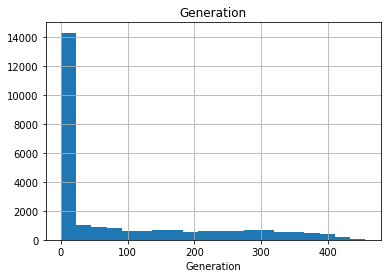

##########################################
Null veri sayısı: 0
count   25560.0000
mean       14.0155
std         9.3449
min       -13.1000
5%         -0.2000
10%         1.8000
20%         4.9000
30%         7.9000
40%        10.8000
50%        13.8000
60%        16.9000
70%        19.6000
80%        22.8000
90%        26.9000
95%        29.3000
99%        33.2000
max        39.0000
Name: AirTemperature, dtype: float64


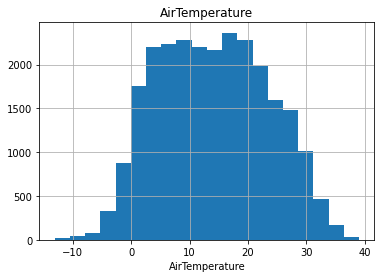

##########################################
Null veri sayısı: 0
count   25560.0000
mean       13.5142
std         9.7431
min       -19.3000
5%         -1.4000
10%         0.7000
20%         3.9000
30%         7.0000
40%        10.3000
50%        13.4000
60%        16.8000
70%        19.8000
80%        23.1000
90%        26.7000
95%        29.0000
99%        32.1000
max        37.2000
Name: ComfortTemperature, dtype: float64


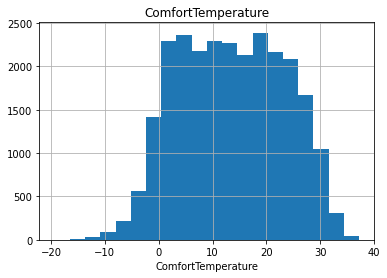

##########################################
Null veri sayısı: 0
count   25560.0000
mean       53.6861
std        22.4059
min         1.6000
5%         17.9000
10%        22.9000
20%        31.7000
30%        39.7000
40%        47.0000
50%        54.2000
60%        61.1000
70%        68.1000
80%        75.4000
90%        83.7100
95%        88.9000
99%        96.0000
max       100.0000
Name: RelativeHumidity, dtype: float64


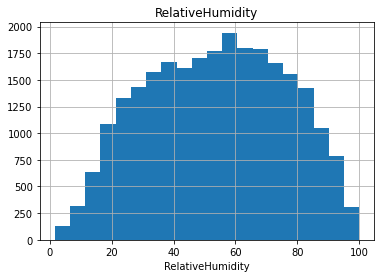

##########################################
Null veri sayısı: 0
count   25560.0000
mean        1.6730
std         1.3582
min         0.0000
5%          0.0000
10%         0.5000
20%         0.5000
30%         0.8000
40%         1.0000
50%         1.5000
60%         1.5000
70%         2.1000
80%         2.6000
90%         3.6000
95%         4.1000
99%         5.7000
max        13.4000
Name: WindSpeed, dtype: float64


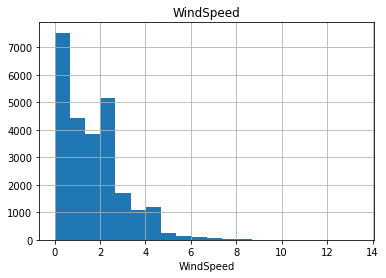

##########################################
Null veri sayısı: 0
count   25560.0000
mean       86.9130
std       100.8251
min         0.0000
5%          0.0000
10%        10.0000
20%        20.0000
30%        20.0000
40%        30.0000
50%        30.0000
60%        40.0000
70%        80.0000
80%       197.0000
90%       240.0000
95%       310.0000
99%       360.0000
max       360.0000
Name: WindDirection, dtype: float64


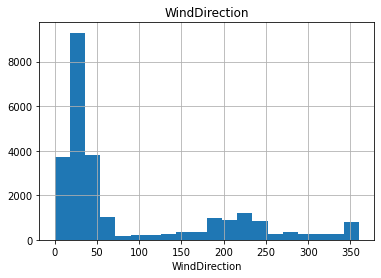

##########################################
Null veri sayısı: 0
count   19306.0000
mean       12.8679
std        24.3262
min         0.0000
5%          0.0000
10%         0.0000
20%         0.0000
30%         0.0000
40%         2.0000
50%         3.0000
60%         4.0000
70%         5.0000
80%        10.0000
90%        60.0000
95%        80.0000
99%        95.0000
max        99.0000
Name: WWCode, dtype: float64


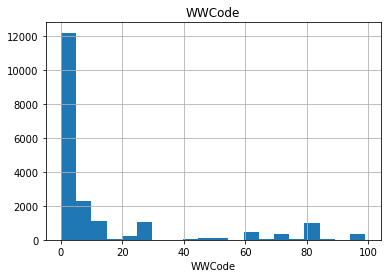

##########################################
Null veri sayısı: 6254
count   25560.0000
mean        2.5738
std         2.4874
min         0.0000
5%          0.0000
10%         0.0000
20%         0.0000
30%         0.0000
40%         0.8000
50%         2.0000
60%         3.0000
70%         4.4000
80%         5.3000
90%         6.0000
95%         6.6000
99%         7.6000
max         8.0000
Name: EffectiveCloudCover, dtype: float64


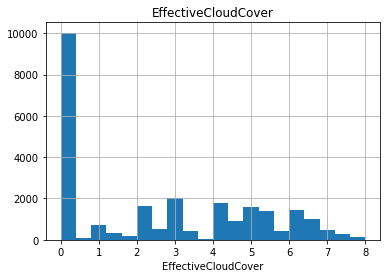

##########################################
Null veri sayısı: 0


In [7]:
#EDA
dataset_ozet(df_train)
cat_deg,num_deg,car_deg=degisken_tiplerine_ayirma(df_train,10,20)
for i in num_deg:
    numeric_ozet(df_train,i,True,True)

In [8]:
split_date = '2021-10-01'
df_train, df_val = split_train(df_train, split_date)
x_train, y_train = create_features(df_train, label='Generation')
x_val, y_val = create_features(df_val, label='Generation')
x_test = create_features(df_test)

Dataset kolon/değişken sayısı: 19
Dataset satır/veri sayısı: 24097
********************************************
Datasetin numeric değişken sayısı: 5
Datasetin numeric değişkenler: ['hour', 'month', 'dayofyear', 'dayofmonth', 'weekofyear']
********************************************
Datasetin categoric değişken sayısı: 14
Datasetin categoric değişkenler: ['NEW_WIND_CAT', 'NEW_Humidity_CAT', 'NEW_TEMP_CAT', 'NEW_CLD_CAT', 'dayofweek', 'quarter', 'year', 'is_Mon', 'is_Tue', 'is_Wed', 'is_Thu', 'is_Fri', 'is_Sat', 'is_Sun']
********************************************
Datasetin cardinal değişken sayısı: 0
Datasetin cardinal değişkenler: []
********************************************
Dataset kolon/değişken sayısı: 19
Dataset satır/veri sayısı: 1463
********************************************
Datasetin numeric değişken sayısı: 4
Datasetin numeric değişkenler: ['hour', 'dayofyear', 'dayofmonth', 'weekofyear']
********************************************
Datasetin categoric değişken sayısı:

In [9]:

df_train.corr(method='pearson')

,Generation,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
Generation,1.0000,0.3742,0.3554,-0.4296,0.0831,0.0896,-0.1640,-0.1158
AirTemperature,0.3742,1.0000,0.9913,-0.7551,0.1378,0.0222,-0.1980,-0.2603
ComfortTemperature,0.3554,0.9913,1.0000,-0.6980,0.0906,0.0120,-0.1866,-0.2508
RelativeHumidity,-0.4296,-0.7551,-0.6980,1.0000,-0.1828,-0.1133,0.3837,0.3754
WindSpeed,0.0831,0.1378,0.0906,-0.1828,1.0000,-0.0565,0.0462,0.0142
WindDirection,0.0896,0.0222,0.0120,-0.1133,-0.0565,1.0000,0.1098,0.1512
WWCode,-0.1640,-0.1980,-0.1866,0.3837,0.0462,0.1098,1.0000,0.5517
EffectiveCloudCover,-0.1158,-0.2603,-0.2508,0.3754,0.0142,0.1512,0.5517,1.0000


In [10]:


missing_cols = set( x_train.columns ) - set( x_val.columns )
for c in missing_cols:
    x_val[c] = 0
    
missing_cols = set( x_val.columns ) - set( x_train.columns )
for c in missing_cols:
    x_train[c] = 0

missing_cols = set( x_train.columns ) - set( x_test.columns )
for c in missing_cols:
    x_test[c] = 0
    
missing_cols = set( x_test.columns ) - set( x_train.columns )
for c in missing_cols:
    x_train[c] = 0
    x_val[c] = 0

x_val=x_val[x_train.columns]
x_test=x_test[x_train.columns]

In [11]:
df_eda=x_train.copy()
df_eda["Generation"]=y_train

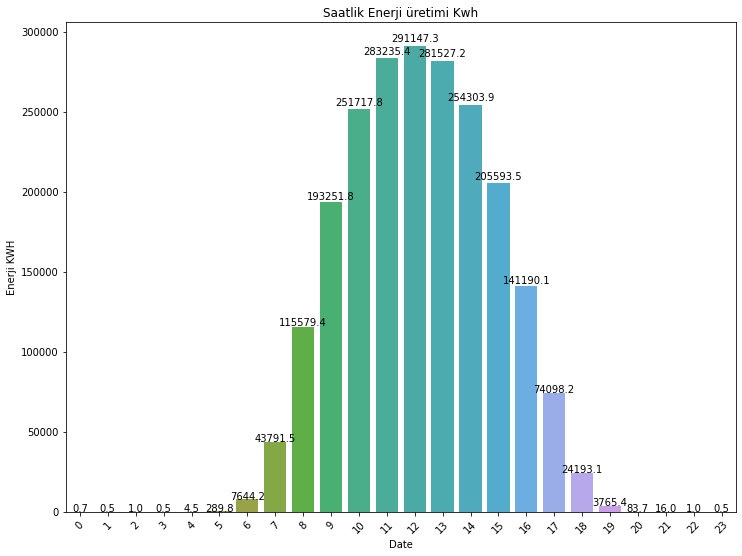

In [12]:
plt.figure(figsize=(12,9))
a=sns.barplot(x=df_eda.groupby(["hour"])["Generation"].sum().index.to_list(),
            y=df_eda.groupby(["hour"])["Generation"].sum())
show_values(a)
plt.xlabel("Date")
plt.ylabel("Enerji KWH")

plt.xticks(rotation=45)
plt.title("Saatlik Enerji üretimi Kwh")
plt.show()

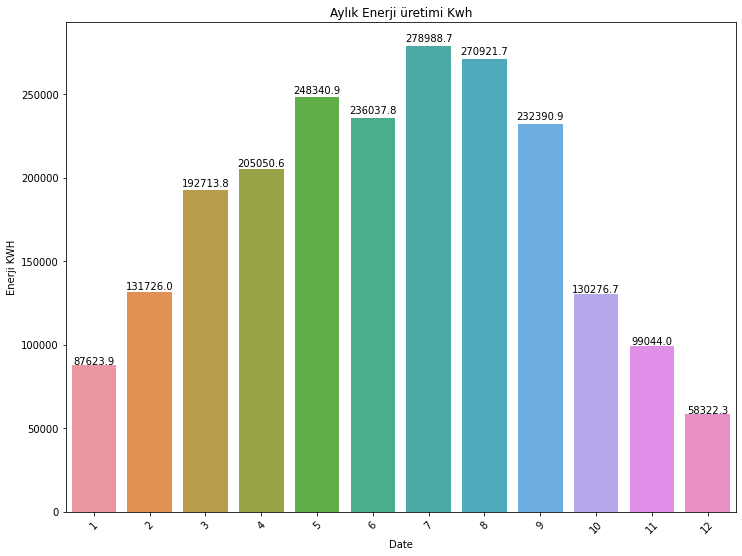

In [13]:
plt.figure(figsize=(12,9))
a=sns.barplot(x=df_eda.groupby(["month"])["Generation"].sum().index.to_list(),
            y=df_eda.groupby(["month"])["Generation"].sum())
show_values(a)
plt.xlabel("Date")
plt.ylabel("Enerji KWH")

plt.xticks(rotation=45)
plt.title("Aylık Enerji üretimi Kwh")
plt.show()

In [14]:
datasets = {'x_train': x_train,
            'y_train': y_train,
            'x_val': x_val,
            'y_val': y_val,
            'x_test': x_test
            }
def pred_model(model, **datasets):
    pred_val = model.predict(datasets['x_val'])
    pred_val = pd.DataFrame(pred_val, index=datasets['x_val'].index, columns=['pred'])
    
    pred_test = model.predict(datasets['x_test'])

    return pred_test, pred_val

In [15]:
def objective_lgb(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.25, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-9, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-9, 100.0)
    subsample = trial.suggest_float("subsample", 0.0001, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.0001, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 50)
    early_stopping_rounds = trial.suggest_int("early_stopping_rounds", 100, 700)
    n_estimators = trial.suggest_int("n_estimators", 0, 10000)
    
    model = LGBMRegressor(
        random_state=50,
        tree_method="gpu_hist",
        gpu_id=0,
        predictor="gpu_predictor",
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
    )
    model.fit(
        datasets['x_train'],
        datasets['y_train'],
        early_stopping_rounds=early_stopping_rounds,
        eval_set=[(datasets['x_val'], datasets['y_val'])],
        verbose=1200,
    )
    preds_valid = model.predict(datasets['x_val'])
    rmse = mean_squared_error(datasets['y_val'], preds_valid, squared=False)

    return rmse
study_lgb = optuna.create_study(direction="minimize")
study_lgb.optimize(objective_lgb, n_trials=120)

[I 2022-03-16 06:29:37,338] A new study created in memory with name: no-name-b387a755-425e-4b79-b42d-eea4ebf878b1


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 544.303
[2400]	valid_0's l2: 529.935


[I 2022-03-16 06:29:44,263] Trial 0 finished with value: 22.989222117029925 and parameters: {'learning_rate': 0.03480671395805352, 'reg_lambda': 22.316048503242932, 'reg_alpha': 8.633278952072529e-07, 'subsample': 0.27247303186405625, 'colsample_bytree': 0.9676494958694575, 'max_depth': 48, 'early_stopping_rounds': 212, 'n_estimators': 6653}. Best is trial 0 with value: 22.989222117029925.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 1336.96


[I 2022-03-16 06:29:50,169] Trial 1 finished with value: 30.93789378529695 and parameters: {'learning_rate': 0.0014948503788427619, 'reg_lambda': 2.1985052351148214e-09, 'reg_alpha': 0.002127964542749939, 'subsample': 0.8117628940866216, 'colsample_bytree': 0.9510513967309491, 'max_depth': 25, 'early_stopping_rounds': 325, 'n_estimators': 1497}. Best is trial 0 with value: 22.989222117029925.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 9332.6
[2400]	valid_0's l2: 5841.29
[3600]	valid_0's l2: 3885.02
[4800]	valid_0's l2: 2687.9
[6000]	valid_0's l2: 1970.83
[7200]	valid_0's l2: 1504.5


[I 2022-03-16 06:30:14,893] Trial 2 finished with value: 38.436946428750865 and parameters: {'learning_rate': 0.000412562195411844, 'reg_lambda': 0.01151156220701721, 'reg_alpha': 5.540254247691585e-05, 'subsample': 0.9542979595763603, 'colsample_bytree': 0.4928114856666454, 'max_depth': 49, 'early_stopping_rounds': 219, 'n_estimators': 7300}. Best is trial 0 with value: 22.989222117029925.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 3698.78


[I 2022-03-16 06:30:22,110] Trial 3 finished with value: 42.00524349482409 and parameters: {'learning_rate': 0.0010832010739050995, 'reg_lambda': 1.9222968036954803e-08, 'reg_alpha': 1.058134156884436e-05, 'subsample': 0.42657302351240717, 'colsample_bytree': 0.5955542376869235, 'max_depth': 19, 'early_stopping_rounds': 316, 'n_estimators': 2075}. Best is trial 0 with value: 22.989222117029925.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:30:23,139] Trial 4 finished with value: 22.331863119040502 and parameters: {'learning_rate': 0.07520316375863591, 'reg_lambda': 2.472952247697097, 'reg_alpha': 5.828274320604621e-05, 'subsample': 0.2722641616801039, 'colsample_bytree': 0.9807094745844486, 'max_depth': 9, 'early_stopping_rounds': 139, 'n_estimators': 8972}. Best is trial 4 with value: 22.331863119040502.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 4951.66
[2400]	valid_0's l2: 2365.71
[3600]	valid_0's l2: 1545.15
[4800]	valid_0's l2: 1167.18
[6000]	valid_0's l2: 1010.62
[7200]	valid_0's l2: 913.729
[8400]	valid_0's l2: 854.969


[I 2022-03-16 06:30:42,868] Trial 5 finished with value: 28.888406276774436 and parameters: {'learning_rate': 0.0030498322161018406, 'reg_lambda': 0.010142143968012059, 'reg_alpha': 0.057048728126868814, 'subsample': 0.44044943491525124, 'colsample_bytree': 0.16312492885834656, 'max_depth': 41, 'early_stopping_rounds': 195, 'n_estimators': 9096}. Best is trial 4 with value: 22.331863119040502.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 1475.97
[2400]	valid_0's l2: 1129.5
[3600]	valid_0's l2: 1027.1
[4800]	valid_0's l2: 948.432
[6000]	valid_0's l2: 909.507


[I 2022-03-16 06:30:50,522] Trial 6 finished with value: 29.848457702391165 and parameters: {'learning_rate': 0.04099643775631249, 'reg_lambda': 3.6953121601836046e-09, 'reg_alpha': 2.3277469095662935e-07, 'subsample': 0.2324893140082635, 'colsample_bytree': 0.057046405779196334, 'max_depth': 12, 'early_stopping_rounds': 615, 'n_estimators': 6803}. Best is trial 4 with value: 22.331863119040502.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 14149.7
[2400]	valid_0's l2: 12815.3
[3600]	valid_0's l2: 11632.8


[I 2022-03-16 06:31:01,148] Trial 7 finished with value: 104.05765613384348 and parameters: {'learning_rate': 0.00012730230143804074, 'reg_lambda': 6.118378869656664e-06, 'reg_alpha': 0.10114813158640276, 'subsample': 0.12887299617431008, 'colsample_bytree': 0.1952335153672516, 'max_depth': 19, 'early_stopping_rounds': 546, 'n_estimators': 4490}. Best is trial 4 with value: 22.331863119040502.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 4154.74
[2400]	valid_0's l2: 2433.03
[3600]	valid_0's l2: 1975.18
[4800]	valid_0's l2: 1712.27


[I 2022-03-16 06:31:08,022] Trial 8 finished with value: 40.46435561201438 and parameters: {'learning_rate': 0.0019335416649288058, 'reg_lambda': 0.028669120750023532, 'reg_alpha': 1.992901962161054e-07, 'subsample': 0.46313600172395875, 'colsample_bytree': 0.49987770376289503, 'max_depth': 2, 'early_stopping_rounds': 176, 'n_estimators': 5310}. Best is trial 4 with value: 22.331863119040502.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:31:09,986] Trial 9 finished with value: 27.815888866268082 and parameters: {'learning_rate': 0.09271625083291563, 'reg_lambda': 0.03265448732495654, 'reg_alpha': 4.848950584412267e-09, 'subsample': 0.7532898887502842, 'colsample_bytree': 0.3954966643264344, 'max_depth': 35, 'early_stopping_rounds': 613, 'n_estimators': 9776}. Best is trial 4 with value: 22.331863119040502.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:31:11,630] Trial 10 finished with value: 22.460138463981604 and parameters: {'learning_rate': 0.23051129891286354, 'reg_lambda': 91.72131897322487, 'reg_alpha': 0.000936655375675563, 'subsample': 0.0016313557717803628, 'colsample_bytree': 0.7350768657167537, 'max_depth': 4, 'early_stopping_rounds': 456, 'n_estimators': 3749}. Best is trial 4 with value: 22.331863119040502.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 1964.38
[2400]	valid_0's l2: 1958.16


[I 2022-03-16 06:31:15,410] Trial 11 finished with value: 44.23719010663765 and parameters: {'learning_rate': 0.19909353187691323, 'reg_lambda': 81.83228544090859, 'reg_alpha': 20.13458633827403, 'subsample': 0.022129911691475875, 'colsample_bytree': 0.761624869407619, 'max_depth': 1, 'early_stopping_rounds': 460, 'n_estimators': 3522}. Best is trial 4 with value: 22.331863119040502.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 509.045
[2400]	valid_0's l2: 500.176


[I 2022-03-16 06:31:23,066] Trial 12 finished with value: 22.358368650463888 and parameters: {'learning_rate': 0.012060619847594973, 'reg_lambda': 2.8305952247231065, 'reg_alpha': 0.0022370890814282693, 'subsample': 0.002117750220038025, 'colsample_bytree': 0.769714228637951, 'max_depth': 9, 'early_stopping_rounds': 437, 'n_estimators': 3059}. Best is trial 4 with value: 22.331863119040502.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:31:25,929] Trial 13 finished with value: 22.331671875124762 and parameters: {'learning_rate': 0.012485604089574564, 'reg_lambda': 1.255939702845883, 'reg_alpha': 0.5140974328480347, 'subsample': 0.2635678248849729, 'colsample_bytree': 0.8548199692141917, 'max_depth': 10, 'early_stopping_rounds': 342, 'n_estimators': 732}. Best is trial 13 with value: 22.331671875124762.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:31:28,843] Trial 14 finished with value: 22.79546017150354 and parameters: {'learning_rate': 0.008274404452676916, 'reg_lambda': 0.9934612002127199, 'reg_alpha': 2.9815791916563463, 'subsample': 0.2673601761294326, 'colsample_bytree': 0.8810819547333367, 'max_depth': 11, 'early_stopping_rounds': 100, 'n_estimators': 838}. Best is trial 13 with value: 22.331671875124762.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:31:30,773] Trial 15 finished with value: 22.420985605064445 and parameters: {'learning_rate': 0.023902169663582454, 'reg_lambda': 9.922240745290575e-05, 'reg_alpha': 0.10370933486697453, 'subsample': 0.5926141882908705, 'colsample_bytree': 0.8549514662431841, 'max_depth': 19, 'early_stopping_rounds': 329, 'n_estimators': 327}. Best is trial 13 with value: 22.331671875124762.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:31:31,741] Trial 16 finished with value: 22.568544721466598 and parameters: {'learning_rate': 0.07615208671754076, 'reg_lambda': 0.7083284948040663, 'reg_alpha': 95.33032254306751, 'subsample': 0.3429894623538256, 'colsample_bytree': 0.6313359273315761, 'max_depth': 28, 'early_stopping_rounds': 107, 'n_estimators': 8240}. Best is trial 13 with value: 22.331671875124762.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 517.418


[I 2022-03-16 06:31:35,737] Trial 17 finished with value: 22.691478656644676 and parameters: {'learning_rate': 0.013374413981443697, 'reg_lambda': 0.00042827112848003985, 'reg_alpha': 1.5311866947806592, 'subsample': 0.5699249069469354, 'colsample_bytree': 0.9865352168368373, 'max_depth': 15, 'early_stopping_rounds': 273, 'n_estimators': 5669}. Best is trial 13 with value: 22.331671875124762.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 490.044


[I 2022-03-16 06:31:42,346] Trial 18 finished with value: 21.7303926783854 and parameters: {'learning_rate': 0.005060602126820664, 'reg_lambda': 6.700845639095353e-07, 'reg_alpha': 3.628241743875462e-05, 'subsample': 0.1497653816536758, 'colsample_bytree': 0.8398068661529975, 'max_depth': 6, 'early_stopping_rounds': 384, 'n_estimators': 2270}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 568.169


[I 2022-03-16 06:31:50,263] Trial 19 finished with value: 22.78770972866909 and parameters: {'learning_rate': 0.005053268291779568, 'reg_lambda': 2.218277117920278e-07, 'reg_alpha': 1.2414739533703194e-09, 'subsample': 0.14129066578966712, 'colsample_bytree': 0.6100572605596071, 'max_depth': 26, 'early_stopping_rounds': 391, 'n_estimators': 2394}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:31:50,524] Trial 20 finished with value: 121.93936039439573 and parameters: {'learning_rate': 0.000753734933142514, 'reg_lambda': 1.0132666841256272e-06, 'reg_alpha': 0.010274718202519708, 'subsample': 0.13637616193272417, 'colsample_bytree': 0.8441812723745274, 'max_depth': 6, 'early_stopping_rounds': 531, 'n_estimators': 44}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 536.948


[I 2022-03-16 06:31:54,466] Trial 21 finished with value: 22.973858935362138 and parameters: {'learning_rate': 0.004414794597055077, 'reg_lambda': 0.0003863005848290132, 'reg_alpha': 7.964665068253645e-05, 'subsample': 0.32960785166322815, 'colsample_bytree': 0.6943346906018912, 'max_depth': 7, 'early_stopping_rounds': 700, 'n_estimators': 1248}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:31:56,920] Trial 22 finished with value: 22.549857719732184 and parameters: {'learning_rate': 0.08076039639524148, 'reg_lambda': 0.20206363344510853, 'reg_alpha': 5.299710875993592e-06, 'subsample': 0.1755875576264517, 'colsample_bytree': 0.8903010025966112, 'max_depth': 15, 'early_stopping_rounds': 377, 'n_estimators': 2273}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:32:00,107] Trial 23 finished with value: 22.339849187620388 and parameters: {'learning_rate': 0.022040464791329383, 'reg_lambda': 2.1091677889729564e-05, 'reg_alpha': 0.00015114731391089692, 'subsample': 0.3766618242678093, 'colsample_bytree': 0.8163969630147189, 'max_depth': 14, 'early_stopping_rounds': 250, 'n_estimators': 4175}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 505.047


[I 2022-03-16 06:32:06,280] Trial 24 finished with value: 22.24912438120692 and parameters: {'learning_rate': 0.007112423986095749, 'reg_lambda': 1.0932030245186236e-07, 'reg_alpha': 7.260640275277799e-06, 'subsample': 0.21102084154552647, 'colsample_bytree': 0.920504121187174, 'max_depth': 8, 'early_stopping_rounds': 164, 'n_estimators': 2826}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 1106.35
[2400]	valid_0's l2: 665.218


[I 2022-03-16 06:32:13,385] Trial 25 finished with value: 24.841914791435247 and parameters: {'learning_rate': 0.005223215523760051, 'reg_lambda': 7.147083022606294e-08, 'reg_alpha': 4.0416531192112164e-08, 'subsample': 0.08400345472704196, 'colsample_bytree': 0.3419646452954156, 'max_depth': 5, 'early_stopping_rounds': 359, 'n_estimators': 2840}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 491.904


[I 2022-03-16 06:32:18,242] Trial 26 finished with value: 22.076147191265942 and parameters: {'learning_rate': 0.007789939786306047, 'reg_lambda': 8.984545011655782e-07, 'reg_alpha': 6.678765939291987e-06, 'subsample': 0.20380208377292475, 'colsample_bytree': 0.7029789940045625, 'max_depth': 31, 'early_stopping_rounds': 284, 'n_estimators': 1507}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 680.195


[I 2022-03-16 06:32:23,775] Trial 27 finished with value: 24.137986443786403 and parameters: {'learning_rate': 0.0032875479514630425, 'reg_lambda': 2.190770001125978e-06, 'reg_alpha': 4.033976161426019e-06, 'subsample': 0.5540676430658846, 'colsample_bytree': 0.6752692625837331, 'max_depth': 39, 'early_stopping_rounds': 283, 'n_estimators': 1492}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 494.047


[I 2022-03-16 06:32:30,481] Trial 28 finished with value: 22.17493580696457 and parameters: {'learning_rate': 0.007701010751599984, 'reg_lambda': 1.7747650985844308e-07, 'reg_alpha': 1.375388283046421e-06, 'subsample': 0.19493973975803616, 'colsample_bytree': 0.796854408080617, 'max_depth': 31, 'early_stopping_rounds': 247, 'n_estimators': 3073}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 1489.08
[2400]	valid_0's l2: 674.212
[3600]	valid_0's l2: 572.604


[I 2022-03-16 06:32:47,023] Trial 29 finished with value: 23.48076381470826 and parameters: {'learning_rate': 0.002247882895734223, 'reg_lambda': 6.397901080210148e-07, 'reg_alpha': 1.0655593334773052e-06, 'subsample': 0.06291259521398795, 'colsample_bytree': 0.5526868889375319, 'max_depth': 32, 'early_stopping_rounds': 226, 'n_estimators': 4740}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 7203.54


[I 2022-03-16 06:32:53,816] Trial 30 finished with value: 70.57772746117186 and parameters: {'learning_rate': 0.000476722821868204, 'reg_lambda': 2.5102784640937407e-08, 'reg_alpha': 2.3080642901229422e-08, 'subsample': 0.37244463218425466, 'colsample_bytree': 0.69207198763709, 'max_depth': 44, 'early_stopping_rounds': 417, 'n_estimators': 1839}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 520.264
[2400]	valid_0's l2: 506.549


[I 2022-03-16 06:33:02,480] Trial 31 finished with value: 22.399679520208945 and parameters: {'learning_rate': 0.0067501048296142434, 'reg_lambda': 1.7402882833770668e-07, 'reg_alpha': 1.4850981106785795e-05, 'subsample': 0.1852081618935848, 'colsample_bytree': 0.9236412752898916, 'max_depth': 34, 'early_stopping_rounds': 169, 'n_estimators': 3125}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 492.198


[I 2022-03-16 06:33:08,972] Trial 32 finished with value: 22.143840172801617 and parameters: {'learning_rate': 0.008726374186168931, 'reg_lambda': 1.2322325295956856e-09, 'reg_alpha': 8.187424958181354e-07, 'subsample': 0.20505408284198368, 'colsample_bytree': 0.8038985298462299, 'max_depth': 29, 'early_stopping_rounds': 298, 'n_estimators': 2704}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 486.139


[I 2022-03-16 06:33:13,095] Trial 33 finished with value: 22.028005699074384 and parameters: {'learning_rate': 0.022115651200120975, 'reg_lambda': 1.5117193016945854e-09, 'reg_alpha': 6.684487461963031e-07, 'subsample': 0.08432804035198085, 'colsample_bytree': 0.7890524662045793, 'max_depth': 29, 'early_stopping_rounds': 294, 'n_estimators': 3911}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:33:16,573] Trial 34 finished with value: 22.262541969133245 and parameters: {'learning_rate': 0.033657520271413055, 'reg_lambda': 1.6952532906108535e-09, 'reg_alpha': 3.271952015839394e-07, 'subsample': 0.08538505514721796, 'colsample_bytree': 0.7301160832445474, 'max_depth': 23, 'early_stopping_rounds': 294, 'n_estimators': 5877}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 540.933


[I 2022-03-16 06:33:22,594] Trial 35 finished with value: 23.1707472211788 and parameters: {'learning_rate': 0.017226462468701846, 'reg_lambda': 9.013478948382561e-09, 'reg_alpha': 4.3832928337312756e-08, 'subsample': 0.6764608423523519, 'colsample_bytree': 0.5547625584666976, 'max_depth': 29, 'early_stopping_rounds': 306, 'n_estimators': 3854}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:33:26,048] Trial 36 finished with value: 23.913123283114754 and parameters: {'learning_rate': 0.033606311195101636, 'reg_lambda': 8.368293303384788e-09, 'reg_alpha': 2.3779740196078327e-05, 'subsample': 0.31175149156173504, 'colsample_bytree': 0.44125528617275206, 'max_depth': 22, 'early_stopping_rounds': 360, 'n_estimators': 1584}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:33:28,462] Trial 37 finished with value: 22.26768682477461 and parameters: {'learning_rate': 0.046763830113789276, 'reg_lambda': 1.0854107001671348e-09, 'reg_alpha': 0.00023939566809717033, 'subsample': 0.9129856027996164, 'colsample_bytree': 0.6497543442114412, 'max_depth': 37, 'early_stopping_rounds': 484, 'n_estimators': 2351}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 619.205


[I 2022-03-16 06:33:32,674] Trial 38 finished with value: 24.857177099302955 and parameters: {'learning_rate': 0.0030888174181694108, 'reg_lambda': 2.5591321247595367e-08, 'reg_alpha': 1.1217571605316538e-06, 'subsample': 0.07665793101409543, 'colsample_bytree': 0.800303549150946, 'max_depth': 43, 'early_stopping_rounds': 217, 'n_estimators': 1209}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 1819.75
[2400]	valid_0's l2: 688.795
[3600]	valid_0's l2: 568.313


[I 2022-03-16 06:33:49,158] Trial 39 finished with value: 23.493291545106874 and parameters: {'learning_rate': 0.0012296716881050043, 'reg_lambda': 6.666261323796193e-06, 'reg_alpha': 2.2440505171767982e-07, 'subsample': 0.12941953383063864, 'colsample_bytree': 0.9582156467100813, 'max_depth': 25, 'early_stopping_rounds': 265, 'n_estimators': 4295}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 12796.5


[I 2022-03-16 06:33:56,007] Trial 40 finished with value: 105.5596386949313 and parameters: {'learning_rate': 0.00013932013201839815, 'reg_lambda': 3.575485073176189e-09, 'reg_alpha': 0.0008298141482170898, 'subsample': 0.23755622026450937, 'colsample_bytree': 0.5733415414844374, 'max_depth': 29, 'early_stopping_rounds': 320, 'n_estimators': 2048}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 490.381


[I 2022-03-16 06:34:02,811] Trial 41 finished with value: 22.0315623291423 and parameters: {'learning_rate': 0.010635950408323993, 'reg_lambda': 3.217115347914639e-05, 'reg_alpha': 9.080603928777613e-07, 'subsample': 0.1949920930885919, 'colsample_bytree': 0.8005103456287457, 'max_depth': 32, 'early_stopping_rounds': 254, 'n_estimators': 3419}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 505.082
[2400]	valid_0's l2: 497.368


[I 2022-03-16 06:34:11,960] Trial 42 finished with value: 22.273604061863082 and parameters: {'learning_rate': 0.010890301845572006, 'reg_lambda': 0.002320034751327592, 'reg_alpha': 2.646504052979191e-06, 'subsample': 0.1606427576408934, 'colsample_bytree': 0.7576155522324932, 'max_depth': 33, 'early_stopping_rounds': 220, 'n_estimators': 5055}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 493.404
[2400]	valid_0's l2: 484.807


[I 2022-03-16 06:34:18,311] Trial 43 finished with value: 21.979238337235856 and parameters: {'learning_rate': 0.01991556460972011, 'reg_lambda': 2.670307644472812e-05, 'reg_alpha': 2.930540123369961e-05, 'subsample': 0.048053566175221024, 'colsample_bytree': 0.7041550268338348, 'max_depth': 38, 'early_stopping_rounds': 294, 'n_estimators': 2567}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 488.589


[I 2022-03-16 06:34:23,930] Trial 44 finished with value: 22.030586810751768 and parameters: {'learning_rate': 0.018606403048490337, 'reg_lambda': 4.5481091715109425e-05, 'reg_alpha': 1.8711574908015072e-05, 'subsample': 0.04957404475967095, 'colsample_bytree': 0.7235125959457875, 'max_depth': 46, 'early_stopping_rounds': 406, 'n_estimators': 3513}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 512.292


[I 2022-03-16 06:34:28,002] Trial 45 finished with value: 22.592788092895255 and parameters: {'learning_rate': 0.05292099962622431, 'reg_lambda': 6.0547381360626964e-05, 'reg_alpha': 6.303033669312288e-05, 'subsample': 0.04368287606415962, 'colsample_bytree': 0.9033664212536296, 'max_depth': 50, 'early_stopping_rounds': 396, 'n_estimators': 3425}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 502.215
[2400]	valid_0's l2: 498.019


[I 2022-03-16 06:34:36,207] Trial 46 finished with value: 22.24457360678454 and parameters: {'learning_rate': 0.020282669188489973, 'reg_lambda': 0.001988314752431997, 'reg_alpha': 2.5410781310203803e-05, 'subsample': 0.0896626783393396, 'colsample_bytree': 0.7346419573135735, 'max_depth': 47, 'early_stopping_rounds': 489, 'n_estimators': 4161}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 969.004
[2400]	valid_0's l2: 790.471


[I 2022-03-16 06:34:39,257] Trial 47 finished with value: 27.661955572616122 and parameters: {'learning_rate': 0.12548820301073257, 'reg_lambda': 1.9375982815310865e-05, 'reg_alpha': 0.004501620923568956, 'subsample': 0.11119501052429803, 'colsample_bytree': 0.030168069983178447, 'max_depth': 37, 'early_stopping_rounds': 419, 'n_estimators': 3492}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:34:43,561] Trial 48 finished with value: 22.393585259250244 and parameters: {'learning_rate': 0.028850678328358907, 'reg_lambda': 0.00012650494062619306, 'reg_alpha': 0.0004361349185516734, 'subsample': 0.03397674470548088, 'colsample_bytree': 0.8412286065413292, 'max_depth': 47, 'early_stopping_rounds': 339, 'n_estimators': 4702}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 506.489


[I 2022-03-16 06:34:47,098] Trial 49 finished with value: 22.49456241144841 and parameters: {'learning_rate': 0.01622753302033425, 'reg_lambda': 4.754834666581048e-06, 'reg_alpha': 2.9639983378481003e-05, 'subsample': 0.02673428677629318, 'colsample_bytree': 0.7676801743882671, 'max_depth': 41, 'early_stopping_rounds': 197, 'n_estimators': 3942}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 2273.99
[2400]	valid_0's l2: 905.011
[3600]	valid_0's l2: 667.127
[4800]	valid_0's l2: 596.694
[6000]	valid_0's l2: 571.859


[I 2022-03-16 06:35:06,705] Trial 50 finished with value: 23.834895172418843 and parameters: {'learning_rate': 0.001961237881738372, 'reg_lambda': 1.536404243245387e-05, 'reg_alpha': 1.2734427587306236e-08, 'subsample': 0.008272672228131467, 'colsample_bytree': 0.46881526632665393, 'max_depth': 36, 'early_stopping_rounds': 365, 'n_estimators': 6233}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 505.87
[2400]	valid_0's l2: 498.8


[I 2022-03-16 06:35:13,952] Trial 51 finished with value: 22.325849507176308 and parameters: {'learning_rate': 0.010207598498569392, 'reg_lambda': 4.643782124574587e-05, 'reg_alpha': 8.113072312976927e-08, 'subsample': 0.2785856978672562, 'colsample_bytree': 0.7082513203995311, 'max_depth': 31, 'early_stopping_rounds': 249, 'n_estimators': 2567}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 508.288


[I 2022-03-16 06:35:19,803] Trial 52 finished with value: 22.426899722477682 and parameters: {'learning_rate': 0.014893698950387613, 'reg_lambda': 5.305271623364386e-07, 'reg_alpha': 7.4476463165952875e-06, 'subsample': 0.146056043558132, 'colsample_bytree': 0.5991691991874473, 'max_depth': 39, 'early_stopping_rounds': 326, 'n_estimators': 3352}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:35:21,765] Trial 53 finished with value: 23.170371141485916 and parameters: {'learning_rate': 0.059377660803789895, 'reg_lambda': 0.0010964498006808348, 'reg_alpha': 5.835276412975252e-07, 'subsample': 0.2441031787111448, 'colsample_bytree': 0.6737251433026438, 'max_depth': 45, 'early_stopping_rounds': 445, 'n_estimators': 707}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 1832.86


[I 2022-03-16 06:35:27,004] Trial 54 finished with value: 33.68534202315975 and parameters: {'learning_rate': 0.004394214157859289, 'reg_lambda': 1.541937354490328e-06, 'reg_alpha': 2.6302346349432083e-06, 'subsample': 0.107075282611063, 'colsample_bytree': 0.24926771523460833, 'max_depth': 27, 'early_stopping_rounds': 266, 'n_estimators': 1974}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 507.9
[2400]	valid_0's l2: 504.129


[I 2022-03-16 06:35:32,949] Trial 55 finished with value: 22.43491945556573 and parameters: {'learning_rate': 0.021860743636671485, 'reg_lambda': 0.00018373901204812921, 'reg_alpha': 0.00012163576233014477, 'subsample': 0.055945362691692826, 'colsample_bytree': 0.6465354025857181, 'max_depth': 39, 'early_stopping_rounds': 417, 'n_estimators': 3710}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:35:35,571] Trial 56 finished with value: 22.34866379729611 and parameters: {'learning_rate': 0.026567097969525926, 'reg_lambda': 3.718457736684179e-06, 'reg_alpha': 1.1739121957978732e-05, 'subsample': 0.2985709245006415, 'colsample_bytree': 0.8360487518818479, 'max_depth': 20, 'early_stopping_rounds': 142, 'n_estimators': 5275}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:35:39,429] Trial 57 finished with value: 22.952357526578698 and parameters: {'learning_rate': 0.006300145335744095, 'reg_lambda': 8.947071275576398e-06, 'reg_alpha': 4.438599715907298e-05, 'subsample': 0.17924004375560104, 'colsample_bytree': 0.8643517819039218, 'max_depth': 24, 'early_stopping_rounds': 383, 'n_estimators': 984}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 498.432


[I 2022-03-16 06:35:44,468] Trial 58 finished with value: 22.212541036565316 and parameters: {'learning_rate': 0.013217814507809867, 'reg_lambda': 3.838548456690537e-05, 'reg_alpha': 0.0005141186804685852, 'subsample': 0.11832885694578327, 'colsample_bytree': 0.7753754683629317, 'max_depth': 34, 'early_stopping_rounds': 351, 'n_estimators': 1868}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 499.425
[2400]	valid_0's l2: 492.185


[I 2022-03-16 06:35:54,586] Trial 59 finished with value: 22.143059941261832 and parameters: {'learning_rate': 0.009309832362661178, 'reg_lambda': 0.014743103780120451, 'reg_alpha': 1.3771313822815828e-07, 'subsample': 0.000839033430260927, 'colsample_bytree': 0.72053806145588, 'max_depth': 42, 'early_stopping_rounds': 310, 'n_estimators': 7132}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 763.556
[2400]	valid_0's l2: 568.112


[I 2022-03-16 06:36:04,781] Trial 60 finished with value: 23.442547044961096 and parameters: {'learning_rate': 0.004063460560639481, 'reg_lambda': 0.0006019245750594584, 'reg_alpha': 2.17155073115308e-06, 'subsample': 0.47110890840430153, 'colsample_bytree': 0.5328834283475554, 'max_depth': 17, 'early_stopping_rounds': 241, 'n_estimators': 3179}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 499.184


[I 2022-03-16 06:36:11,530] Trial 61 finished with value: 22.24766322886012 and parameters: {'learning_rate': 0.009487269068986564, 'reg_lambda': 0.008658752475702662, 'reg_alpha': 3.7323010679778516e-07, 'subsample': 0.007090707047318104, 'colsample_bytree': 0.7332132468193985, 'max_depth': 41, 'early_stopping_rounds': 308, 'n_estimators': 8119}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 513.695


[I 2022-03-16 06:36:16,205] Trial 62 finished with value: 22.599039114194742 and parameters: {'learning_rate': 0.017826332910900106, 'reg_lambda': 0.17510040079017983, 'reg_alpha': 6.420392643576398e-09, 'subsample': 0.05287286359551992, 'colsample_bytree': 0.615169784886705, 'max_depth': 43, 'early_stopping_rounds': 277, 'n_estimators': 6948}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 512.75


[I 2022-03-16 06:36:23,955] Trial 63 finished with value: 22.352160495610487 and parameters: {'learning_rate': 0.006287332814411826, 'reg_lambda': 11.165972215433852, 'reg_alpha': 9.810767722209719e-08, 'subsample': 0.1513394796791801, 'colsample_bytree': 0.7012793056287693, 'max_depth': 46, 'early_stopping_rounds': 290, 'n_estimators': 9961}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 752.035
[2400]	valid_0's l2: 518.039
[3600]	valid_0's l2: 495.888


[I 2022-03-16 06:36:38,573] Trial 64 finished with value: 22.186590925587414 and parameters: {'learning_rate': 0.002401011149454336, 'reg_lambda': 0.006872427013592286, 'reg_alpha': 1.5740707477091648e-07, 'subsample': 0.2144971586030087, 'colsample_bytree': 0.8197973926803424, 'max_depth': 49, 'early_stopping_rounds': 332, 'n_estimators': 9228}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 497.181
[2400]	valid_0's l2: 490.317


[I 2022-03-16 06:36:47,558] Trial 65 finished with value: 22.12050329628484 and parameters: {'learning_rate': 0.012695332579359377, 'reg_lambda': 3.8045741819558664e-07, 'reg_alpha': 6.196417010899186e-06, 'subsample': 0.09516743056170299, 'colsample_bytree': 0.7821549698547486, 'max_depth': 30, 'early_stopping_rounds': 378, 'n_estimators': 8270}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 507.374
[2400]	valid_0's l2: 505.354


[I 2022-03-16 06:36:55,794] Trial 66 finished with value: 22.456043734496966 and parameters: {'learning_rate': 0.01262810283068911, 'reg_lambda': 4.917158865558605e-08, 'reg_alpha': 6.7930524084683215e-06, 'subsample': 0.09563363179371939, 'colsample_bytree': 0.9437948506648733, 'max_depth': 31, 'early_stopping_rounds': 468, 'n_estimators': 2696}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:36:57,645] Trial 67 finished with value: 22.560449241744596 and parameters: {'learning_rate': 0.041675142343836465, 'reg_lambda': 3.811545997416476e-07, 'reg_alpha': 1.323453214027834e-05, 'subsample': 0.39807844286193406, 'colsample_bytree': 0.8746228754996515, 'max_depth': 27, 'early_stopping_rounds': 408, 'n_estimators': 7835}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:37:00,674] Trial 68 finished with value: 22.655697310802097 and parameters: {'learning_rate': 0.024156691866083248, 'reg_lambda': 1.5432227056777083e-06, 'reg_alpha': 0.00014076427295274757, 'subsample': 0.1670206698163884, 'colsample_bytree': 0.9925275625788699, 'max_depth': 35, 'early_stopping_rounds': 434, 'n_estimators': 1619}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 498.204


[I 2022-03-16 06:37:07,138] Trial 69 finished with value: 22.1296279374515 and parameters: {'learning_rate': 0.006009470558007324, 'reg_lambda': 0.00025190208361652275, 'reg_alpha': 5.584978428712712e-05, 'subsample': 0.06701953890325871, 'colsample_bytree': 0.7754490811687019, 'max_depth': 32, 'early_stopping_rounds': 187, 'n_estimators': 2311}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 905.209
[2400]	valid_0's l2: 697.794


[I 2022-03-16 06:37:11,931] Trial 70 finished with value: 25.620911412456277 and parameters: {'learning_rate': 0.0037919018612509368, 'reg_lambda': 3.0321675619010863e-06, 'reg_alpha': 3.481830519972283e-06, 'subsample': 0.22222146776069784, 'colsample_bytree': 0.6762351713228231, 'max_depth': 3, 'early_stopping_rounds': 518, 'n_estimators': 2938}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 503.323


[I 2022-03-16 06:37:18,867] Trial 71 finished with value: 22.184866022383293 and parameters: {'learning_rate': 0.005454343074530204, 'reg_lambda': 0.0002734658524999064, 'reg_alpha': 6.14929298738457e-05, 'subsample': 0.06759984416425004, 'colsample_bytree': 0.7687916221684029, 'max_depth': 30, 'early_stopping_rounds': 150, 'n_estimators': 2347}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 491.289


[I 2022-03-16 06:37:26,076] Trial 72 finished with value: 22.02126962851946 and parameters: {'learning_rate': 0.007646360228716464, 'reg_lambda': 1.1313068476547956e-05, 'reg_alpha': 1.9957109712260004e-05, 'subsample': 0.12425643041071217, 'colsample_bytree': 0.8169673039032984, 'max_depth': 33, 'early_stopping_rounds': 118, 'n_estimators': 4422}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 494.375


[I 2022-03-16 06:37:31,995] Trial 73 finished with value: 22.176706982612753 and parameters: {'learning_rate': 0.008095341980324975, 'reg_lambda': 8.071345415594214e-07, 'reg_alpha': 1.6131435272328447e-05, 'subsample': 0.1272577922730231, 'colsample_bytree': 0.82004695330472, 'max_depth': 33, 'early_stopping_rounds': 371, 'n_estimators': 4486}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 503.517


[I 2022-03-16 06:37:36,298] Trial 74 finished with value: 22.438897629305966 and parameters: {'learning_rate': 0.014521479820603428, 'reg_lambda': 1.1477797762241616e-05, 'reg_alpha': 6.562854499691849e-07, 'subsample': 0.1881950145661987, 'colsample_bytree': 0.9060699791616169, 'max_depth': 26, 'early_stopping_rounds': 396, 'n_estimators': 4009}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:37:39,801] Trial 75 finished with value: 22.102653833740103 and parameters: {'learning_rate': 0.03204708995738994, 'reg_lambda': 3.512442012283407e-05, 'reg_alpha': 1.4304827011797886e-06, 'subsample': 0.2544325435100054, 'colsample_bytree': 0.8005011614585954, 'max_depth': 37, 'early_stopping_rounds': 346, 'n_estimators': 4834}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:37:42,018] Trial 76 finished with value: 22.196106606190952 and parameters: {'learning_rate': 0.03654096033512884, 'reg_lambda': 2.9571019402670028e-05, 'reg_alpha': 1.8401241045303726e-06, 'subsample': 0.2586201831846951, 'colsample_bytree': 0.7491703795488126, 'max_depth': 37, 'early_stopping_rounds': 115, 'n_estimators': 4867}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 493.931


[I 2022-03-16 06:37:46,166] Trial 77 finished with value: 22.19295749331783 and parameters: {'learning_rate': 0.01873723758762014, 'reg_lambda': 8.997700595603308e-05, 'reg_alpha': 0.00020581115937010842, 'subsample': 0.34997632461023204, 'colsample_bytree': 0.8700290722893619, 'max_depth': 39, 'early_stopping_rounds': 348, 'n_estimators': 5656}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:37:47,891] Trial 78 finished with value: 22.893676964288577 and parameters: {'learning_rate': 0.06945319777675592, 'reg_lambda': 7.106334226974146e-06, 'reg_alpha': 0.002655499372342152, 'subsample': 0.16802799750427377, 'colsample_bytree': 0.8354770154482064, 'max_depth': 35, 'early_stopping_rounds': 231, 'n_estimators': 4442}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 505.356
[2400]	valid_0's l2: 502.747


[I 2022-03-16 06:37:57,140] Trial 79 finished with value: 22.419421300367894 and parameters: {'learning_rate': 0.010636133333789773, 'reg_lambda': 8.381305343920761e-05, 'reg_alpha': 2.896683357785566e-05, 'subsample': 0.2883334880995262, 'colsample_bytree': 0.9318726385586648, 'max_depth': 33, 'early_stopping_rounds': 614, 'n_estimators': 3708}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 1054.38
[2400]	valid_0's l2: 858.042


[I 2022-03-16 06:38:02,989] Trial 80 finished with value: 28.46504952063177 and parameters: {'learning_rate': 0.030352232595268935, 'reg_lambda': 2.9838093722969603e-05, 'reg_alpha': 1.3655288588913992e-06, 'subsample': 0.6846628137834875, 'colsample_bytree': 0.09664315729328637, 'max_depth': 28, 'early_stopping_rounds': 123, 'n_estimators': 3261}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 498.55


[I 2022-03-16 06:38:08,329] Trial 81 finished with value: 22.234453264605165 and parameters: {'learning_rate': 0.012083953537118408, 'reg_lambda': 2.3240196819091316e-07, 'reg_alpha': 4.789108374964669e-06, 'subsample': 0.10427005426007702, 'colsample_bytree': 0.7954852327580024, 'max_depth': 31, 'early_stopping_rounds': 383, 'n_estimators': 5058}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:38:10,486] Trial 82 finished with value: 22.309581361602945 and parameters: {'learning_rate': 0.021621443415473254, 'reg_lambda': 2.0601807386404382e-06, 'reg_alpha': 4.3892366225565774e-07, 'subsample': 0.13869640815817044, 'colsample_bytree': 0.7966301825682033, 'max_depth': 30, 'early_stopping_rounds': 262, 'n_estimators': 4183}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 489.007


[I 2022-03-16 06:38:14,948] Trial 83 finished with value: 22.109027975549214 and parameters: {'learning_rate': 0.015937572647500967, 'reg_lambda': 8.362451027035475e-08, 'reg_alpha': 9.842930305434832e-06, 'subsample': 0.035949557021432245, 'colsample_bytree': 0.8893256609692852, 'max_depth': 38, 'early_stopping_rounds': 203, 'n_estimators': 6264}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 520.951


[I 2022-03-16 06:38:20,423] Trial 84 finished with value: 22.542639446774697 and parameters: {'learning_rate': 0.007726425861389516, 'reg_lambda': 7.964987947251789e-08, 'reg_alpha': 1.620108528512999e-05, 'subsample': 0.026657137521700618, 'colsample_bytree': 0.8949314615774849, 'max_depth': 40, 'early_stopping_rounds': 208, 'n_estimators': 6064}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 506.582
[2400]	valid_0's l2: 498.675


[I 2022-03-16 06:38:28,879] Trial 85 finished with value: 22.325414715277667 and parameters: {'learning_rate': 0.016012333699721423, 'reg_lambda': 1.2485082768255742e-08, 'reg_alpha': 0.00010589354963759562, 'subsample': 0.04518686511254228, 'colsample_bytree': 0.9728422035276982, 'max_depth': 37, 'early_stopping_rounds': 288, 'n_estimators': 3580}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:38:30,886] Trial 86 finished with value: 22.353443010378196 and parameters: {'learning_rate': 0.02728630782166827, 'reg_lambda': 3.9360516026779554e-09, 'reg_alpha': 8.692640656723451e-06, 'subsample': 0.2013383805548929, 'colsample_bytree': 0.8552084850000119, 'max_depth': 36, 'early_stopping_rounds': 181, 'n_estimators': 4574}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:38:31,810] Trial 87 finished with value: 23.044537483114436 and parameters: {'learning_rate': 0.11705074149255665, 'reg_lambda': 4.1782422002552566e-08, 'reg_alpha': 3.627757812715305e-06, 'subsample': 0.24860990978609804, 'colsample_bytree': 0.6614609336578537, 'max_depth': 33, 'early_stopping_rounds': 157, 'n_estimators': 5578}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 508.391


[I 2022-03-16 06:38:35,838] Trial 88 finished with value: 22.543388149663528 and parameters: {'learning_rate': 0.042702632171803756, 'reg_lambda': 1.7360257907176043e-05, 'reg_alpha': 9.805436878095686e-07, 'subsample': 0.128145492567332, 'colsample_bytree': 0.6310650704198293, 'max_depth': 38, 'early_stopping_rounds': 321, 'n_estimators': 6559}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 778.632
[2400]	valid_0's l2: 518.952


[I 2022-03-16 06:38:44,993] Trial 89 finished with value: 22.64840935201884 and parameters: {'learning_rate': 0.0025545517954217644, 'reg_lambda': 6.231662376009177e-06, 'reg_alpha': 4.0727140408837475e-05, 'subsample': 0.9694284103251358, 'colsample_bytree': 0.7433109873366366, 'max_depth': 35, 'early_stopping_rounds': 204, 'n_estimators': 2591}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 522.658


[I 2022-03-16 06:38:49,554] Trial 90 finished with value: 22.60014825843913 and parameters: {'learning_rate': 0.005058716663402844, 'reg_lambda': 1.0667829863318665e-06, 'reg_alpha': 0.0003102340973760975, 'subsample': 0.03151453385779143, 'colsample_bytree': 0.7157004340542442, 'max_depth': 34, 'early_stopping_rounds': 258, 'n_estimators': 1378}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 492.409


[I 2022-03-16 06:38:54,775] Trial 91 finished with value: 22.159041547191418 and parameters: {'learning_rate': 0.01916843055351773, 'reg_lambda': 3.62052192346378e-07, 'reg_alpha': 4.6528267438178474e-06, 'subsample': 0.07573043253902506, 'colsample_bytree': 0.7892482420717531, 'max_depth': 28, 'early_stopping_rounds': 339, 'n_estimators': 8890}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 493.144


[I 2022-03-16 06:39:01,101] Trial 92 finished with value: 22.120959739966416 and parameters: {'learning_rate': 0.010604863745196367, 'reg_lambda': 2.0050289009445712e-07, 'reg_alpha': 9.133337161280888e-06, 'subsample': 0.09179511765735271, 'colsample_bytree': 0.8172516160426355, 'max_depth': 30, 'early_stopping_rounds': 232, 'n_estimators': 7396}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 508.745


[I 2022-03-16 06:39:08,305] Trial 93 finished with value: 22.33187667914008 and parameters: {'learning_rate': 0.007044913725747674, 'reg_lambda': 0.0001326699815665364, 'reg_alpha': 2.2654456790072354e-05, 'subsample': 0.1558701760843128, 'colsample_bytree': 0.8554789607549937, 'max_depth': 36, 'early_stopping_rounds': 357, 'n_estimators': 3996}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 504.007


[I 2022-03-16 06:39:13,750] Trial 94 finished with value: 22.394236744151396 and parameters: {'learning_rate': 0.013587130917522446, 'reg_lambda': 1.1324712433948236e-05, 'reg_alpha': 2.4910794889121095e-06, 'subsample': 0.11010075533953725, 'colsample_bytree': 0.8858473434598122, 'max_depth': 32, 'early_stopping_rounds': 300, 'n_estimators': 5341}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:39:17,099] Trial 95 finished with value: 22.172209602369353 and parameters: {'learning_rate': 0.03529253634144262, 'reg_lambda': 1.1217037298445368e-07, 'reg_alpha': 2.4842959833988084e-07, 'subsample': 0.8591161113698705, 'colsample_bytree': 0.6869684543830541, 'max_depth': 21, 'early_stopping_rounds': 276, 'n_estimators': 8590}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:39:19,782] Trial 96 finished with value: 22.15116503969617 and parameters: {'learning_rate': 0.05213692006543822, 'reg_lambda': 4.258093671882227e-06, 'reg_alpha': 1.5212347090147695e-06, 'subsample': 0.22976187547983007, 'colsample_bytree': 0.8352890363061278, 'max_depth': 13, 'early_stopping_rounds': 380, 'n_estimators': 2979}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method


[I 2022-03-16 06:39:22,651] Trial 97 finished with value: 22.35143789367321 and parameters: {'learning_rate': 0.024978296953811773, 'reg_lambda': 5.5763105570428235e-05, 'reg_alpha': 6.756031977994194e-06, 'subsample': 0.05927067490617537, 'colsample_bytree': 0.7484561550824566, 'max_depth': 38, 'early_stopping_rounds': 324, 'n_estimators': 1750}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 491.149
[2400]	valid_0's l2: 488.608
[3600]	valid_0's l2: 485.581


[I 2022-03-16 06:39:34,038] Trial 98 finished with value: 22.016257218974367 and parameters: {'learning_rate': 0.00906429512079554, 'reg_lambda': 2.953041004126033e-06, 'reg_alpha': 7.081122925041049e-07, 'subsample': 0.5322745669801974, 'colsample_bytree': 0.786755734257903, 'max_depth': 27, 'early_stopping_rounds': 405, 'n_estimators': 9371}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 711.763


[I 2022-03-16 06:39:40,125] Trial 99 finished with value: 24.94775250477712 and parameters: {'learning_rate': 0.00888414236985748, 'reg_lambda': 2.670737471211338e-06, 'reg_alpha': 6.554225551368548e-07, 'subsample': 0.5168772295388445, 'colsample_bytree': 0.35057916520641275, 'max_depth': 26, 'early_stopping_rounds': 436, 'n_estimators': 2188}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 506.316


[I 2022-03-16 06:39:44,664] Trial 100 finished with value: 22.488409225618142 and parameters: {'learning_rate': 0.016755190387428304, 'reg_lambda': 2.2678385088746212e-05, 'reg_alpha': 6.747756837527787e-08, 'subsample': 0.6070536547003681, 'colsample_bytree': 0.9180881084468714, 'max_depth': 24, 'early_stopping_rounds': 409, 'n_estimators': 4368}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 489.935
[2400]	valid_0's l2: 483.616
[3600]	valid_0's l2: 481.444


[I 2022-03-16 06:39:56,800] Trial 101 finished with value: 21.8784269093993 and parameters: {'learning_rate': 0.011475041207983962, 'reg_lambda': 4.918798037557624e-07, 'reg_alpha': 3.422392697311234e-05, 'subsample': 0.4972826471932097, 'colsample_bytree': 0.7832764709737249, 'max_depth': 29, 'early_stopping_rounds': 365, 'n_estimators': 9288}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 490.901
[2400]	valid_0's l2: 489.054
[3600]	valid_0's l2: 485.89


[I 2022-03-16 06:40:09,068] Trial 102 finished with value: 22.015489814482656 and parameters: {'learning_rate': 0.01083464056646, 'reg_lambda': 7.136875534231284e-07, 'reg_alpha': 7.410707230074567e-05, 'subsample': 0.6408512799826819, 'colsample_bytree': 0.822294329378335, 'max_depth': 27, 'early_stopping_rounds': 394, 'n_estimators': 9603}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 490.979
[2400]	valid_0's l2: 485.406


[I 2022-03-16 06:40:16,551] Trial 103 finished with value: 21.99883748437936 and parameters: {'learning_rate': 0.010897336552385953, 'reg_lambda': 1.4427574969669886e-06, 'reg_alpha': 4.503139287468478e-05, 'subsample': 0.758838692105551, 'colsample_bytree': 0.8124746111255943, 'max_depth': 27, 'early_stopping_rounds': 424, 'n_estimators': 9534}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 590.489
[2400]	valid_0's l2: 502.425
[3600]	valid_0's l2: 498.363
[4800]	valid_0's l2: 495.867
[6000]	valid_0's l2: 492.747


[I 2022-03-16 06:40:37,724] Trial 104 finished with value: 22.169305160991197 and parameters: {'learning_rate': 0.0034505990125253544, 'reg_lambda': 5.641266619850603e-07, 'reg_alpha': 0.0008712333945929956, 'subsample': 0.7539574163004339, 'colsample_bytree': 0.7596839743580263, 'max_depth': 27, 'early_stopping_rounds': 473, 'n_estimators': 9471}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 490.999
[2400]	valid_0's l2: 482.751


[I 2022-03-16 06:40:46,510] Trial 105 finished with value: 21.949770293933415 and parameters: {'learning_rate': 0.007732122662927586, 'reg_lambda': 1.0996295945105436e-06, 'reg_alpha': 7.990267335594779e-05, 'subsample': 0.6313985609064907, 'colsample_bytree': 0.818233645891938, 'max_depth': 23, 'early_stopping_rounds': 449, 'n_estimators': 9552}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 495.406


[I 2022-03-16 06:40:51,002] Trial 106 finished with value: 22.236468989328703 and parameters: {'learning_rate': 0.010918678571223915, 'reg_lambda': 1.3821791761370651e-06, 'reg_alpha': 0.0001014700532502108, 'subsample': 0.6692238402350581, 'colsample_bytree': 0.8224335913586461, 'max_depth': 23, 'early_stopping_rounds': 420, 'n_estimators': 9681}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 525.357
[2400]	valid_0's l2: 489.049
[3600]	valid_0's l2: 485.272


[I 2022-03-16 06:41:01,777] Trial 107 finished with value: 22.022722533136324 and parameters: {'learning_rate': 0.004617405534565582, 'reg_lambda': 2.0971859911202754e-06, 'reg_alpha': 0.00018258417417747926, 'subsample': 0.6357025378850899, 'colsample_bytree': 0.8440212067897197, 'max_depth': 24, 'early_stopping_rounds': 494, 'n_estimators': 9413}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 520.723
[2400]	valid_0's l2: 498.566
[3600]	valid_0's l2: 496.026
[4800]	valid_0's l2: 493.883
[6000]	valid_0's l2: 493.298


[I 2022-03-16 06:41:19,445] Trial 108 finished with value: 22.199035381642016 and parameters: {'learning_rate': 0.005633065357313908, 'reg_lambda': 8.248770071692099e-07, 'reg_alpha': 0.0004466705366256629, 'subsample': 0.6172860501872312, 'colsample_bytree': 0.8587440020915872, 'max_depth': 25, 'early_stopping_rounds': 506, 'n_estimators': 9324}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 498.249
[2400]	valid_0's l2: 490.268


[I 2022-03-16 06:41:28,261] Trial 109 finished with value: 22.11829587200905 and parameters: {'learning_rate': 0.007004511998481652, 'reg_lambda': 2.0682977023018238e-06, 'reg_alpha': 0.010306482891549605, 'subsample': 0.646718397894794, 'colsample_bytree': 0.7781134378636685, 'max_depth': 17, 'early_stopping_rounds': 551, 'n_estimators': 8783}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 553.767
[2400]	valid_0's l2: 506.886
[3600]	valid_0's l2: 501.941
[4800]	valid_0's l2: 499.224
[6000]	valid_0's l2: 495.967


[I 2022-03-16 06:41:47,573] Trial 110 finished with value: 22.25065115498368 and parameters: {'learning_rate': 0.004247390837878368, 'reg_lambda': 4.262085095887456e-06, 'reg_alpha': 7.024704181248069e-05, 'subsample': 0.7292599996536262, 'colsample_bytree': 0.7206018769952515, 'max_depth': 23, 'early_stopping_rounds': 447, 'n_estimators': 9618}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 494.489
[2400]	valid_0's l2: 485.9


[I 2022-03-16 06:41:55,506] Trial 111 finished with value: 22.037469091256874 and parameters: {'learning_rate': 0.00845864212199269, 'reg_lambda': 1.098099192737409e-05, 'reg_alpha': 3.9760484250949804e-05, 'subsample': 0.5418758207186345, 'colsample_bytree': 0.814117021919272, 'max_depth': 29, 'early_stopping_rounds': 429, 'n_estimators': 9148}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 527.003
[2400]	valid_0's l2: 495.135


[I 2022-03-16 06:42:04,211] Trial 112 finished with value: 22.234239613197875 and parameters: {'learning_rate': 0.004768941445362695, 'reg_lambda': 6.34961221692784e-06, 'reg_alpha': 0.0002578351239245587, 'subsample': 0.5726475321709568, 'colsample_bytree': 0.8444002936695314, 'max_depth': 24, 'early_stopping_rounds': 550, 'n_estimators': 9472}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 492.28


[I 2022-03-16 06:42:10,333] Trial 113 finished with value: 22.114885834987394 and parameters: {'learning_rate': 0.009493302727116288, 'reg_lambda': 2.87729695396475e-07, 'reg_alpha': 2.1777510525479346e-05, 'subsample': 0.7167251032585155, 'colsample_bytree': 0.8300967726470355, 'max_depth': 27, 'early_stopping_rounds': 463, 'n_estimators': 9872}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 503.177
[2400]	valid_0's l2: 499.84


[I 2022-03-16 06:42:18,162] Trial 114 finished with value: 22.323136429374735 and parameters: {'learning_rate': 0.011582439838834205, 'reg_lambda': 2.826987962662765e-06, 'reg_alpha': 0.0001887076232868941, 'subsample': 0.7892335445039058, 'colsample_bytree': 0.8063345363157068, 'max_depth': 28, 'early_stopping_rounds': 451, 'n_estimators': 9385}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 689.138
[2400]	valid_0's l2: 513.383
[3600]	valid_0's l2: 503.574


[I 2022-03-16 06:42:32,826] Trial 115 finished with value: 22.40999861691543 and parameters: {'learning_rate': 0.0028288928237352163, 'reg_lambda': 1.2587598351417963e-06, 'reg_alpha': 8.687094706718943e-05, 'subsample': 0.4851226752840843, 'colsample_bytree': 0.7566423764445759, 'max_depth': 25, 'early_stopping_rounds': 400, 'n_estimators': 9074}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 528.481
[2400]	valid_0's l2: 512.527
[3600]	valid_0's l2: 508.145


[I 2022-03-16 06:42:45,972] Trial 116 finished with value: 22.541110666234676 and parameters: {'learning_rate': 0.006346085188331589, 'reg_lambda': 4.652625182076134e-07, 'reg_alpha': 0.0012747616107191277, 'subsample': 0.44873692574418433, 'colsample_bytree': 0.8756597239656627, 'max_depth': 29, 'early_stopping_rounds': 577, 'n_estimators': 8691}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 498.285


[I 2022-03-16 06:42:52,945] Trial 117 finished with value: 22.158799011107718 and parameters: {'learning_rate': 0.014147822803669403, 'reg_lambda': 1.3232863167462503e-07, 'reg_alpha': 0.00015601808282593907, 'subsample': 0.6443196060402886, 'colsample_bytree': 0.7842089930149363, 'max_depth': 20, 'early_stopping_rounds': 425, 'n_estimators': 9582}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 502.507


[I 2022-03-16 06:42:59,969] Trial 118 finished with value: 22.282026396496278 and parameters: {'learning_rate': 0.007330673375884182, 'reg_lambda': 1.3647013001455993e-05, 'reg_alpha': 3.587342934604896e-05, 'subsample': 0.8683286473517537, 'colsample_bytree': 0.736892863688243, 'max_depth': 26, 'early_stopping_rounds': 495, 'n_estimators': 8457}. Best is trial 18 with value: 21.7303926783854.


[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[1200]	valid_0's l2: 2154.58
[2400]	valid_0's l2: 2002.24
[3600]	valid_0's l2: 1985.15
[4800]	valid_0's l2: 1973.01
[6000]	valid_0's l2: 1970.83
[7200]	valid_0's l2: 1970.12


[I 2022-03-16 06:43:06,659] Trial 119 finished with value: 44.38165374047119 and parameters: {'learning_rate': 0.019885582952446364, 'reg_lambda': 6.673947027741007e-07, 'reg_alpha': 0.0005342064213865979, 'subsample': 0.5212216961787435, 'colsample_bytree': 0.84654061854772, 'max_depth': 1, 'early_stopping_rounds': 407, 'n_estimators': 9988}. Best is trial 18 with value: 21.7303926783854.


In [16]:
optuna_params_lgb = study_lgb.best_params
optuna_params_lgb

{'learning_rate': 0.005060602126820664,
 'reg_lambda': 6.700845639095353e-07,
 'reg_alpha': 3.628241743875462e-05,
 'subsample': 0.1497653816536758,
 'colsample_bytree': 0.8398068661529975,
 'max_depth': 6,
 'early_stopping_rounds': 384,
 'n_estimators': 2270}

In [17]:
model = LGBMRegressor(
    random_state=50,
    tree_method="gpu_hist",
    gpu_id=0,
    predictor="gpu_predictor",
    **optuna_params_lgb
)
model.fit(
    datasets['x_train'],
    datasets['y_train'],
    early_stopping_rounds=optuna_params_lgb['early_stopping_rounds'],
    eval_set=[(datasets['x_val'], datasets['y_val'])],
    verbose=1000,
)

[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] early_stopping_round is set=384, early_stopping_rounds=384 will be ignored. Current value: early_stopping_round=384
[1000]	valid_0's l2: 512.974
[2000]	valid_0's l2: 475.181


LGBMRegressor(colsample_bytree=0.8398068661529975, early_stopping_rounds=384,
              gpu_id=0, learning_rate=0.005060602126820664, max_depth=6,
              n_estimators=2270, predictor='gpu_predictor', random_state=50,
              reg_alpha=3.628241743875462e-05, reg_lambda=6.700845639095353e-07,
              subsample=0.1497653816536758, tree_method='gpu_hist')

In [18]:
pred_optuna_lgb, pred_val_optuna_lgb = pred_model(model, **datasets)

In [19]:
cols=df_train.columns
lgb_params = {'metric': {'mae'},
              'num_leaves': 8,

              'learning_rate': 0.03,
              'feature_fraction': 0.9,
              'max_depth': 3,
              'verbose': 0,
              

              'num_boost_round': 20000,
              'early_stopping_rounds': 300,
              'nthread': -1}

lgbtrain = lgb.Dataset(data=x_train, label=y_train, feature_name=cols)
lgbval = lgb.Dataset(data=x_val, label=y_val, reference=lgbtrain, feature_name=cols)

In [20]:
def clip_nights(pred, test = False):
    nights = [21,22 , 23 , 0, 1, 2, 3,4]
    if not test:
        for time, row in pred.iterrows():
            if time.hour in nights or row['pred'] < 0:
                row['pred'] = 0
        return pred
    else:
        for i, hour in enumerate(pd.to_datetime(pred['DateTime'])):
            if hour.hour in nights or pred.loc[i, 'Generation'] < 0:
                pred.loc[i, 'Generation'] = 0
        return pred

pred_val_optuna_lgb = clip_nights(pred_val_optuna_lgb)


In [21]:
pred_val_optuna_lgb.head()

,pred
DateTime,
2021-10-01 01:00:00,0.0000
2021-10-01 02:00:00,0.0000
2021-10-01 03:00:00,0.0000
2021-10-01 04:00:00,0.0000
2021-10-01 05:00:00,3.0396


In [22]:
df_train.tail()

,Generation,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
DateTime,,,,,,,,
2021-09-30 20:00:00,0.0000,13.7000,13.0000,45.8000,3.6000,30.0000,0.0000,0.0000
2021-09-30 21:00:00,0.0000,12.5000,11.9000,49.8000,2.6000,30.0000,0.0000,0.0000
2021-09-30 22:00:00,0.0000,11.6000,11.1000,54.8000,1.5000,20.0000,0.0000,0.0000
2021-09-30 23:00:00,0.0000,10.6000,10.1000,56.9000,0.0000,0.0000,0.0000,0.0000
2021-10-01 00:00:00,0.0000,9.6000,9.2000,63.0000,0.0000,0.0000,0.0000,0.0000


In [23]:
split_date = '2021-8-01'
_, df_eda = split_train(df_train, split_date)


In [24]:
y_eda=df_eda["Generation"]

In [25]:
y_pred=y_val.copy()
y_pred=pred_val_optuna_lgb["pred"]

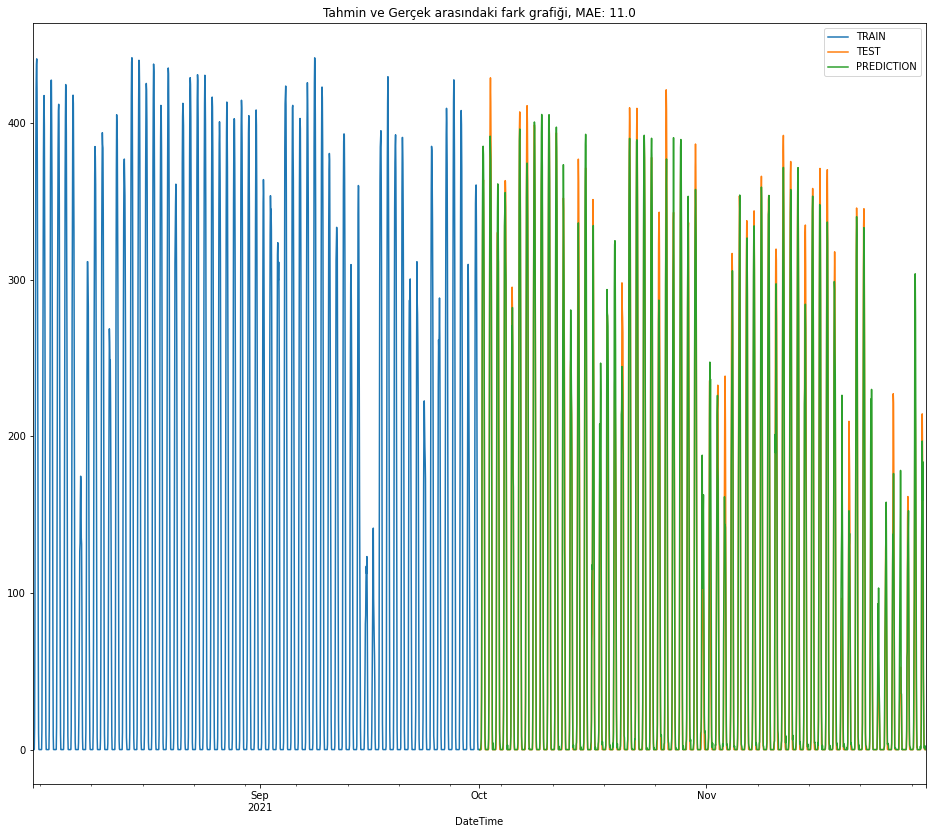

In [26]:
plot_difference(y_eda, y_val, y_pred, "Tahmin ve Gerçek arasındaki fark grafiği")

In [27]:
# model = lgb.train(lgb_params, lgbtrain,
#                   valid_sets=[lgbtrain, lgbval],
#                   num_boost_round=lgb_params['num_boost_round'],
#                   early_stopping_rounds=lgb_params['early_stopping_rounds'],
#                   feval=lgbm_smape,
# #                   verbose_eval=100
#                  )

# # y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

# # smape(np.expm1(y_pred_val), np.expm1(Y_val))
# def plot_lgb_importances(model, plot=False, num=10):

#     gain = model.feature_importance('gain')
#     feat_imp = pd.DataFrame({'feature': model.feature_name(),
#                              'split': model.feature_importance('split'),
#                              'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
#     if plot:
#         plt.figure(figsize=(10, 10))
#         sns.set(font_scale=1)
#         sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
#         plt.title('feature')
#         plt.tight_layout()
#         plt.show()
#     else:
#         print(feat_imp.head(num))


# plot_lgb_importances(model, num=30)
# plot_lgb_importances(model, num=30, plot=True)

# lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
# plt.show()

In [28]:
rmse_optuna_lgb = mean_squared_error(datasets['y_val'], pred_val_optuna_lgb, squared=False)
print('Optuna RMSE LGBM: ', rmse_optuna_lgb)

Optuna RMSE LGBM:  21.651593074185904


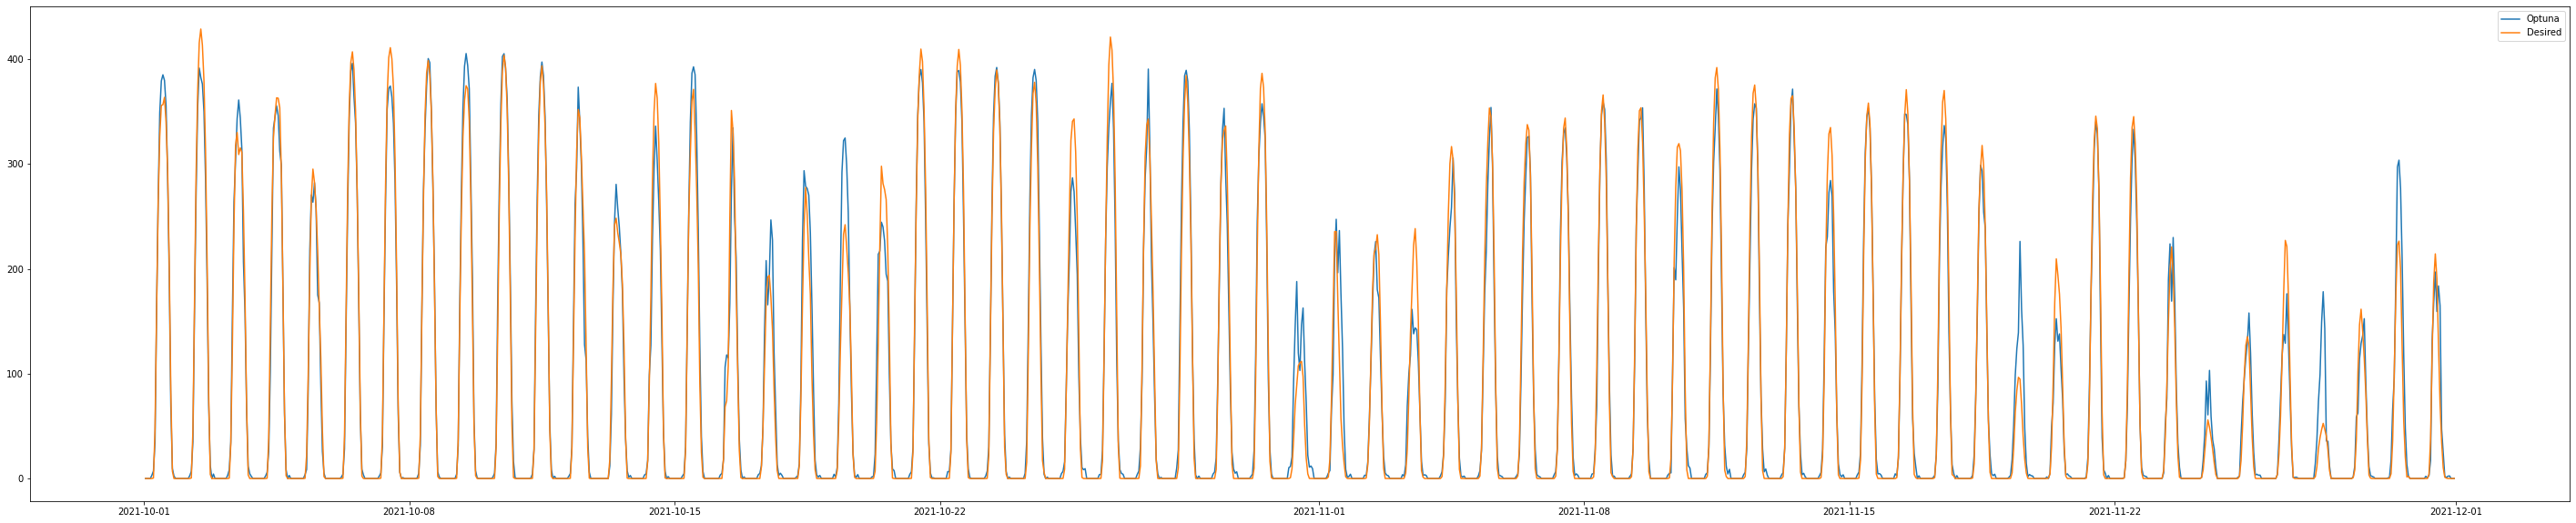

83.33175172658918 pred   83.9327
dtype: float64
11.321736158578254 14.179092833132824


In [29]:
plt.figure(figsize=(50,10))
plt.plot(pred_val_optuna_lgb)
plt.plot(y_val)
plt.legend(['Optuna', 'Desired'])
plt.show()
print(y_val.mean(),pred_val_optuna_lgb.mean())
print(x_val.AirTemperature.mean(),x_train.AirTemperature.mean())

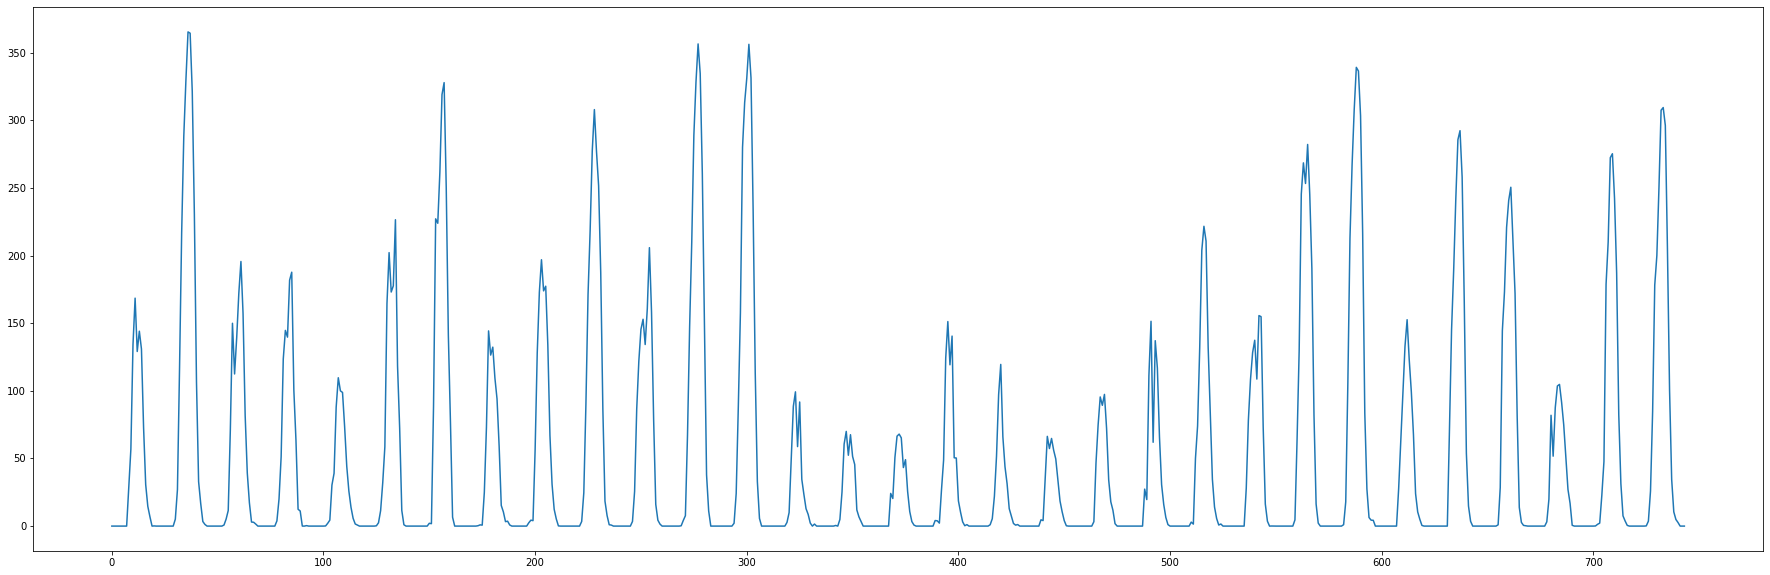

In [30]:
submission = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/sample_submission.csv')
submission['Generation'] = pred_optuna_lgb
submission = clip_nights(submission, test=True)
plt.figure(figsize=(31,10))
plt.plot(submission['Generation'])
plt.show()

In [31]:
submission.to_csv('submission.csv', index=False)